# Preparing the environment for EDA

In [1]:
# Imports of Models & libraries. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import nltk
import os
import string   
import re
import squarify

from pywaffle import Waffle
from datetime import datetime
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob
from scipy.stats import norm
from collections import Counter
from nltk import PorterStemmer
from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
central_london = pd.read_csv('Central_London.csv')

In [3]:
# View Metadata
central_london.info()
# 758,162 rows of data with top row for headers
# Some un-named columns, need to explore what they contain

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048366 entries, 0 to 1048365
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Survey wave (calendar quarter)  758163 non-null  object 
 1   Equivalent financial quarter    758163 non-null  object 
 2   Site ID                         758163 non-null  object 
 3   Location                        758163 non-null  object 
 4   Survey date                     748007 non-null  object 
 5   Weather                         746329 non-null  object 
 6   Time                            758163 non-null  object 
 7   Period                          758163 non-null  object 
 8   Direction                       758163 non-null  object 
 9   Start hour                      758163 non-null  float64
 10  Start minute                    758163 non-null  float64
 11  Number of private cycles        758099 non-null  float64
 12  Number of cycl

In [5]:
# Look at random sample of data
central_london.sample(5)

,Survey wave (calendar quarter),Equivalent financial quarter,Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles,Unnamed: 14,Unnamed: 15,Unnamed: 16
1031748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
790010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310932,2017 Q1 (January-March),2016-17 Q4,CENCY022,Northumberland Avenue,"lun, 30/01/17",Fine,1100 - 1115,Inter-peak (10:00-16:00),Westbound,11.0,0.0,3.0,1.0,4.0,NaN,NaN,NaN
25780,2014 Q2 (April-June),2014-15 Q1,CENCY003,Southwark Bridge,"ven, 25/04/14",Wet,1900 - 1915,Evening (19:00-22:00),Southbound,19.0,0.0,40.0,2.0,42.0,NaN,NaN,NaN
656251,2020 Q3 (July-September),2020-21 Q2,CENCY021,Buckingham Palace Road,"mar, 07/07/20",Wet,2045 - 2100,Evening (19:00-22:00),Northbound,20.0,45.0,4.0,1.0,5.0,NaN,NaN,NaN


# Data Wrangling

In [6]:
# Rename columns to remove space in column names
central_london.columns = central_london.columns.str.replace(' ','_')

In [7]:
# Drop empty columns
central_london.dropna(how='all', axis=1, inplace=True)
# Drop empty rows
central_london.dropna(how='all')

,Survey_wave_(calendar_quarter),Equivalent_financial_quarter,Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Start_hour,Start_minute,Number_of_private_cycles,Number_of_cycle_hire_bikes,Total_cycles
0,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6.0,0.0,0.0,0.0,0.0
1,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,6.0,15.0,15.0,0.0,15.0
2,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6.0,30.0,35.0,0.0,35.0
3,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,6.0,45.0,59.0,2.0,61.0
4,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,7.0,0.0,73.0,0.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758158,2021 Q4 (October-December),2021-22 Q3,CENCY702,Haymarket,"mar, 21/12/21",Dry,2045 - 2100,Evening (19:00-22:00),Southbound,20.0,45.0,22.0,1.0,23.0
758159,2021 Q4 (October-December),2021-22 Q3,CENCY702,Haymarket,"mar, 21/12/21",Dry,2100 - 2115,Evening (19:00-22:00),Southbound,21.0,0.0,20.0,0.0,20.0
758160,2021 Q4 (October-December),2021-22 Q3,CENCY702,Haymarket,"mar, 21/12/21",Dry,2115 - 2130,Evening (19:00-22:00),Southbound,21.0,15.0,16.0,1.0,17.0
758161,2021 Q4 (October-December),2021-22 Q3,CENCY702,Haymarket,"mar, 21/12/21",Dry,2130 - 2145,Evening (19:00-22:00),Southbound,21.0,30.0,10.0,1.0,11.0


In [8]:
# Parse Dates correctly
# Remove French Day name in Survey Date 
central_london["Survey_date"] = central_london["Survey_date"].str.replace(r'\D+', '', regex=True)

# Convert to datetime format
central_london['Survey_date'] = pd.to_datetime(central_london.Survey_date)

# Define day of the week in English and add back as a column
central_london['Day_of_week'] = central_london['Survey_date'].dt.day_name()

# Pass Month into a new column
central_london['month'] = central_london['Survey_date'].dt.month

In [9]:
# Pass Season
# Create function for user defined seasons
def f(x):
    if (x >= 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
central_london['season'] = central_london['month'].apply(f)

In [10]:
# Check missing values
central_london.isnull().sum()

# Relatively large number. 
# Drop the ones without survey date.

Survey_wave_(calendar_quarter)    290203
Equivalent_financial_quarter      290203
Site_ID                           290203
Location                          290203
Survey_date                       300615
Weather                           302037
Time                              290203
Period                            290203
Direction                         290203
Start_hour                        290203
Start_minute                      290203
Number_of_private_cycles          290267
Number_of_cycle_hire_bikes        290267
Total_cycles                      290203
Day_of_week                       300615
month                             300615
season                            300615
dtype: int64

In [11]:
# View null value examples
central_london[central_london['Survey_date'].isnull()]

,Survey_wave_(calendar_quarter),Equivalent_financial_quarter,Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Start_hour,Start_minute,Number_of_private_cycles,Number_of_cycle_hire_bikes,Total_cycles,Day_of_week,month,season
114368,2015 Q1 (January-March),2014-15 Q4,CENCY094,Houndsditch,NaT,NaN,0600 - 0615,Early Morning (06:00-07:00),Eastbound,6.0,0.0,2.0,1.0,3.0,NaN,NaN,None
114369,2015 Q1 (January-March),2014-15 Q4,CENCY094,Houndsditch,NaT,NaN,0615 - 0630,Early Morning (06:00-07:00),Eastbound,6.0,15.0,2.0,1.0,3.0,NaN,NaN,None
114370,2015 Q1 (January-March),2014-15 Q4,CENCY094,Houndsditch,NaT,NaN,0630 - 0645,Early Morning (06:00-07:00),Eastbound,6.0,30.0,2.0,0.0,2.0,NaN,NaN,None
114371,2015 Q1 (January-March),2014-15 Q4,CENCY094,Houndsditch,NaT,NaN,0645 - 0700,Early Morning (06:00-07:00),Eastbound,6.0,45.0,2.0,0.0,2.0,NaN,NaN,None
114372,2015 Q1 (January-March),2014-15 Q4,CENCY094,Houndsditch,NaT,NaN,0700 - 0715,AM peak (07:00-10:00),Eastbound,7.0,0.0,5.0,1.0,6.0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048361,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1048362,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1048363,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1048364,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [12]:
# Drop rows if missing values in Survey_date column
central_london = central_london.dropna(subset=['Survey_date'])
# Discuss with team

In [13]:
# Recheck output
central_london.isnull().sum()

# Can see 4626 rows where missing value from weather is uniquely missing.
# Few more missing values in cycles. Revisit these

Survey_wave_(calendar_quarter)       0
Equivalent_financial_quarter         0
Site_ID                              0
Location                             0
Survey_date                          0
Weather                           4626
Time                                 0
Period                               0
Direction                            0
Start_hour                           0
Start_minute                         0
Number_of_private_cycles            64
Number_of_cycle_hire_bikes          64
Total_cycles                         0
Day_of_week                          0
month                                0
season                               0
dtype: int64

In [14]:
# View Metadata now
central_london.info()
# 747750 rows of data left 
# 10,412 rows of data deleted.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747751 entries, 0 to 758162
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Survey_wave_(calendar_quarter)  747751 non-null  object        
 1   Equivalent_financial_quarter    747751 non-null  object        
 2   Site_ID                         747751 non-null  object        
 3   Location                        747751 non-null  object        
 4   Survey_date                     747751 non-null  datetime64[ns]
 5   Weather                         743125 non-null  object        
 6   Time                            747751 non-null  object        
 7   Period                          747751 non-null  object        
 8   Direction                       747751 non-null  object        
 9   Start_hour                      747751 non-null  float64       
 10  Start_minute                    747751 non-null  float64

In [15]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
central_london['Sum'] = central_london['Number_of_private_cycles'] + central_london['Number_of_cycle_hire_bikes']

# Dropping rows where the column values dont add up 
central_london = central_london[central_london.Total_cycles == central_london.Sum]

# Look at output
central_london.info()

# 64 rows dropped where total cycles doesnt add up

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747687 entries, 0 to 758162
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Survey_wave_(calendar_quarter)  747687 non-null  object        
 1   Equivalent_financial_quarter    747687 non-null  object        
 2   Site_ID                         747687 non-null  object        
 3   Location                        747687 non-null  object        
 4   Survey_date                     747687 non-null  datetime64[ns]
 5   Weather                         743061 non-null  object        
 6   Time                            747687 non-null  object        
 7   Period                          747687 non-null  object        
 8   Direction                       747687 non-null  object        
 9   Start_hour                      747687 non-null  float64       
 10  Start_minute                    747687 non-null  float64

In [16]:
# Drop the redundant columns to reduce size of dataFrame & memomry consumption
central_london.drop(['Sum', 'Start_hour', 'Start_minute', 'month', 'Equivalent_financial_quarter'], axis=1)

,Survey_wave_(calendar_quarter),Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Number_of_private_cycles,Number_of_cycle_hire_bikes,Total_cycles,Day_of_week,season
0,2014 Q1 (January-March),CENCY001,Millbank (south of Thorney Street),2014-01-24,Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,0.0,0.0,0.0,Friday,Winter
1,2014 Q1 (January-March),CENCY001,Millbank (south of Thorney Street),2014-01-24,Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,15.0,0.0,15.0,Friday,Winter
2,2014 Q1 (January-March),CENCY001,Millbank (south of Thorney Street),2014-01-24,Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,35.0,0.0,35.0,Friday,Winter
3,2014 Q1 (January-March),CENCY001,Millbank (south of Thorney Street),2014-01-24,Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,59.0,2.0,61.0,Friday,Winter
4,2014 Q1 (January-March),CENCY001,Millbank (south of Thorney Street),2014-01-24,Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,73.0,0.0,73.0,Friday,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
758158,2021 Q4 (October-December),CENCY702,Haymarket,2021-12-21,Dry,2045 - 2100,Evening (19:00-22:00),Southbound,22.0,1.0,23.0,Tuesday,Winter
758159,2021 Q4 (October-December),CENCY702,Haymarket,2021-12-21,Dry,2100 - 2115,Evening (19:00-22:00),Southbound,20.0,0.0,20.0,Tuesday,Winter
758160,2021 Q4 (October-December),CENCY702,Haymarket,2021-12-21,Dry,2115 - 2130,Evening (19:00-22:00),Southbound,16.0,1.0,17.0,Tuesday,Winter
758161,2021 Q4 (October-December),CENCY702,Haymarket,2021-12-21,Dry,2130 - 2145,Evening (19:00-22:00),Southbound,10.0,1.0,11.0,Tuesday,Winter


In [17]:
# Drop the additional information in Survey wave column 
# alligns with the way this info is presented in the other London datasets.
central_london["Survey_wave_(calendar_quarter)"] = central_london["Survey_wave_(calendar_quarter)"].str.replace(r'\D+', '', regex=True)

# Drop the last number in every row 
central_london['Survey_wave_(calendar_quarter)'] = central_london['Survey_wave_(calendar_quarter)'].astype(str).str[:-1].astype(np.int64)

# Rename Column Name to align with other London Datasets
central_london.rename(columns={'Survey_wave_(calendar_quarter)': 'Survey_wave_(year)'}, inplace = True)

In [18]:
central_london.sample(5)

,Survey_wave_(year),Equivalent_financial_quarter,Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Start_hour,Start_minute,Number_of_private_cycles,Number_of_cycle_hire_bikes,Total_cycles,Day_of_week,month,season,Sum
370193,2017,2017-18 Q2,CENCY084,Southwark Street,2017-05-09,Cloudy,1015 - 1030,Inter-peak (10:00-16:00),Westbound,10.0,15.0,10.0,2.0,12.0,Tuesday,5.0,Spring,12.0
649360,2020,2019-20 Q4,CENCY178,Carlisle Place,2020-02-27,Dry,1000 - 1015,Inter-peak (10:00-16:00),Southbound,10.0,0.0,1.0,0.0,1.0,Thursday,2.0,Winter,1.0
746755,2021,2021-22 Q3,CENCY121,Claremont Square,2021-04-10,Wet,1800 - 1815,PM peak (16:00-19:00),Southbound,18.0,0.0,27.0,0.0,27.0,Saturday,4.0,Spring,27.0
256457,2016,2016-17 Q1,CENCY200,Marshalsea Road,2016-04-28,Dry,0815 - 0830,AM peak (07:00-10:00),Eastbound,8.0,15.0,3.0,0.0,3.0,Thursday,4.0,Spring,3.0
396994,2017,2017-18 Q3,CENCY085,Newington Causeway,2017-04-12,Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6.0,30.0,36.0,0.0,36.0,Wednesday,4.0,Spring,36.0


In [19]:
# Count unique values in each column
for col in central_london:
  print(col,": ", central_london[col].nunique())

# More site ids vs location again.
# May imply multiple sites in same location. Does this double count? Need to check!
# Survey period of 8 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 282 types of weather needs to be discussed and trimmed with team

Survey_wave_(year) :  8
Equivalent_financial_quarter :  29
Site_ID :  210
Location :  205
Survey_date :  1596
Weather :  282
Time :  64
Period :  5
Direction :  4
Start_hour :  16
Start_minute :  4
Number_of_private_cycles :  435
Number_of_cycle_hire_bikes :  87
Total_cycles :  478
Day_of_week :  7
month :  12
season :  4
Sum :  478


In [20]:
# Explore the different types of Weather
print(central_london.Weather.unique())

# Lots of overlaps for e.g. Rain & Wet, Dry/cold and dry Cold.
# Need to classify into much narrower streams. 
# Discuss with team tomorrow & then initiate replacements.
# Doing the obvious ones now

['Dry' 'Wet' 'Rain' 'Fine' 'Damp' 'Showery' 'Cold/rain' 'Light Rain'
 'Slightly Wet' 'Rain Stopped' 'Road Wet' 'Almost Dry' 'Light Shower'
 'Rain Damp' 'Rain Dry' 'Wet Damp' 'Very Wet' 'V Wet' 'Wet - Dry'
 'Dry - Wet' 'Dry - Rain' 'Damp - Rain' 'Wet/ Dry' 'S. Wet' 'V. Wet'
 'Wet Intermittently' 'Cloudy/ Rain' 'Windy/ Rain' 'Cold/ Rain' 'Drizzle'
 'Lt Rain' 'Dry & Sunny' 'Spitting' 'Showers' nan 'Cloudy' 'Sunny'
 'Light Showers' 'Hazy' 'Shower' 'Foggy' 'Dull' 'Wet/dry' 'Kdry'
 'Partly Cloudy' 'Rainy' 'Wet T' 'Sun' 'Fair' 'Slight Drizzle'
 'Very Heavy Rain' 'Mild' 'Wet + Windy' 'Blustery' 'Rain/wind'
 'Fine Windy' 'Dry Windy' 'Dry Wet Road' 'Deluge' 'Dry/wet' 'Dry & Wet'
 'V Light Rain' 'Dry A.m Wet P.m' 'Wet Road' 'Cold' 'Cloudy/rain'
 'Wet & Windy' 'Windy' 'Down Pour' 'Dry & Very Windy' 'Mist'
 'Cold Windy Dry' 'Drty' 'Dry (windy)' 'Wet (windy)' 'Fine (windy)'
 'Road Drying Sun Out' 'Dryish' 'Wetish' 'Light Shrs' 'Dry & Windy'
 'Some Showers' 'Rains' 'Dry/sunny' 'Dry/cloudy' 'Dry/hot' 

In [23]:
# Replace some obvious duplications in Weather
# Rain
central_london['Weather'] = central_london['Weather'].replace(['Wet','Cloudy/rain','Rain','Mix Wet/dry','Drizzle',
                                                          'Light Showers', 'Mizzle','Windy/rain','Showers',
                                                          'Wet/dry','Wet/damp','Shower','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower'
                                                          'Light Rain','Shower/dry','Spitting','Drizzle/cloudy',
                                                          'Dry/wet','Damp', 'Dry/drizzle','Dull/damp','Dry-wet',
                                                          'Wet/mix', 'Drizzle/wet','Wet/windy','Rain Shower',
                                                          'Intermittent Showers','Cloudy/drizzle','Rain/drizzle',
                                                          'Wet Road','Drizzle/dry','Drizzle/rain','Mixed Sunny + Rain',
                                                          'Wet/rain', 'V Light Drizzle', 'Rainy', 'W','Slight Drizzle',
                                                          'Rain Stopped', 'Stopped Raining','Wet Rain Stopped','Raining/wet',
                                                          'Showery','Overcast/rain','Rain/wet','Rain/showers','Showers/sunny',
                                                          'Drizzle/showers','Wet/stop Raining','Drizzle Rain','Drizzle Wet',
                                                          'Damp/sun','Raining','Dry + Wet','Showers/cloudy','Cloudy/showers',
                                                          'Getting Wet','Wet Road:sun','Dry But Wet Road','Drizze',
                                                          'wet','Wettish','Light Rain','S.wet','S/w','Cold/rain',
                                                           'Slightly Wet','Road Wet','Light Shower','Rain Damp','Wet Damp',
                                                              'Wet - Dry','Dry - Wet','Rain Dry','Dry - Rain','Damp - Rain',
                                                              'Wet/ Dry','S. Wet','Cloudy/ Rain','Windy/ Rain','Wet T',
                                                              'Some Showers','Rains','Sunny/rainy','Wetr','Showers Mix',
                                                              'Rain/dry','Rain/cloudy','Shower/wet','Wetter',
                                                              'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)','Wet (shower)','Blustery','V. Wet',
                                                              'Rain & Thunder','Rain-heavy','H Rain','Wert','(rain After)',
                                                              'Cloud/rain','Really Wet','Periods Of Rain Quite Windy',
                                                              'Steady Rain'],'Rain')

# Good
central_london['Weather'] = central_london['Weather'].replace(['Sunny','Cloudy Sunny','Sun Setting','Good','Dry/sunny',
                                                          'Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry', 'Warm + Dry','Dry','Dry                         9',
                                                          'Sunny','Cloudy/sunny','Druy','Dry/hot','Dry Warm',
                                                          'Dry/sun','Dryish','Clear And Dry','Clear and Dry','Dry, Warm',
                                                          'Dry, Sunny, Warm','Cloudy with Clear Intervals','Clear and Warm',
                                                          'Dry But Misty','Sunny & Warm All Day','Clear','Dry + Sunny',
                                                          'Sunny/dry','Dr Ry','Dry Y','D','Warm/dry','Bright/dry','Dry Sunny',
                                                          'Fair','Dry/sun','Kdry','Fine Windy',
                                                               'Cloudy','Sunny Overcast Sunny','Sunny/cloudy',
                                                               'Cloudy/rain/sunny','Cloudy + Sunny','Sunny + Cloudy',
                                                               'Cloudy/sunny','Bright + Cloudy','Cloudy/dry',
                                                               'Partly Sunny','Dull','Dry & Mild','Cloud','Overcast',
                                                               'Mild','Overcast (No Rain)','Cloudy bright intervals',
                                                               'Generally overcast','Cloudy with clear spells',
                                                               'Sunny Overcast','Dry','Dry/mild', 'Clear',
                                                               'Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy','Hazy','Partly Cloudy',
                                                               'Drty','Dry (windy)','Fine (windy)','Sunny Cloudy',
                                                              'Dry Dark','Dark','Dry Mon','Dry Wed','Dry Thu','Dry Fri',
                                                              'Sun/rain','Thunder','Cloudy','Sunny Overcast Sunny',
                                                               'Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy','Hazy','Partly Cloudy',
                                                               'Drty','Dry (windy)','Fine (windy)','Sunny Cloudy',
                                                              'Dry Dark','Dark','Dry Mon','Dry Wed','Dry Thu','Dry Fri',
                                                              'Sun/rain','Thunder','Ddry','Dy','Dry/sunny/cold','Fine Cold',
                                                              'Cold Dry','Dry & Cold','Dry And Fine','Dry And Sunny',
                                                              'Dry And Warm','Fine And Dry','Warm + Sunny','Warm And Humid',
                                                              'Warm And Windy','Overcast And Dull','Cloudy And Warm',
                                                              'Sunny Periods And Warm','Dry And Windy','Dry And Very Windy',
                                                              'Warm Sunny And Windy','Hot And Humid','Mild And Sunny',
                                                               'Warm And Overcast','Sunny & Windy','Windy/cloudy',
                                                              'Dry/gusty','Coldish','Windy/dry','Dry But A Bit Windy',
                                                               'Sunny Cold','Cold At First Then Warm/sunny',
                                                              'Warm & Sunny Chilly Later','Fine + Dry Chilly At First',
                                                               'Fine & Sunny','dry','A Bit Chilly At First',
                                                               'Warm With A Slight Wind','Cold Then Dry And Windy',
                                                               'Dry And Overcast','Warm + Sunny Cloudy + Windy',
                                                              'Dry 3/4 Dry','Sunny Until Evening But Windy',
                                                               'Winds Rather Chilly','Warm','Sunny But Very Windy',
                                                               'Now Starts To Get Chilly'],'Good')


# Light Rain
central_london['Weather'] = central_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle','Light Rain',
                                                           'Lt Rain','Drizzle','Intermittent Drizzle', 'Damp','Getting Dry',
                                                           'Dry & Wet','Slight Drizzle/dry','Wet Intermittently',
                                                               'Light Rain','V Light Rain','Dry Wet Road','Dry A.m Wet P.m',
                                                               'Mist','Road Drying Sun Out','Wetish','Light Shrs',
                                                              'Fine Drizzle','V Light Shrs','L/rain','Rain Stopped-dry',
                                                              'V Lt Rain','V.light Rain','Dry (+brief Speels Of Drizzle',
                                                              'Wet (spitting)','Drizzly Rain','Almost Dry','Damp & Drizzly',
                                                              'Dry Road Wet With Leaves','Wet Drizzle','No Rain Wet Roads',
                                                              'Dry But Wet Roads','Very Light Rain','Light Drizzle',
                                                              'Dry/wet Road Surface','V Light Showers','V. Light Rain',
                                                              'Wet/cloudy','Wet/sunny','Dry Road Still Wet',
                                                              '2 Snowflakes Otherwise Dry','Wet-dry','Dry/drizzly',
                                                              'Wet/light Showers','Wet/drizzle','Wet And Windy',
                                                              'Drizzling','Drizzle Damp','Windy Showery','Wet + Dry',
                                                              'V.light Drizzle','Very Light Drizzle','Drying Up','Wet Again',
                                                              'Cold Sunny Rain','Wet First Then Dry','Wetr First Then Dry',
                                                              'Dry With Intermitent Rain','(drizzle)','Damp/misty/wet',
                                                              'Dry But Rain Threatening','Slight Drizzle Till End',
                                                              'Damp/misty','Cold & Dry Early Rain Later',
                                                              'Wet ','Windy/drizzle','Intermitent Light Showers',
                                                              'Intermitent Light Rain','A Few Rain Showers','Drizzly',
                                                              'Rain Looking Likely','A Few Drops Of Rain'],'Light Rain')

# Dangerous Weather
central_london['Weather'] = central_london['Weather'].replace(['Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot',
                                                           'Dry (road Wet)','Dry, Sunny, Hot','Very Heavy Rain',
                                                           'Intermittent Heavy Showers','Very Hot/dry','Hot/dry',
                                                           'Storm','Heavy Rain High Winds','V Wet','Rain Heavy',
                                                          'Sunny (hot!)','Heavy Thunder','Overcast/rain Heavy Showers',
                                                          'Too Cold','High Wind','Very Windy','Dry & Very Windy',
                                                              'Very Hot Dry','Wet/windy','Wet/v.windy','Wet Hail',
                                                               'Rain/hail','Foggy Wet',
                                                           'Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Rain/sleet','Hail Stone',
                                                          'Hail','Showers/hailstone','Rain/hailstone','Cold/ Rain',
                                                              'Foggy','Wet & Windy','Wet + Windy','Rain/wind',
                                                              'Wet (windy)','Occasional Lt Snow Shrs',
                                                              'Wet And Very Windy','Dry Chill','Dry/cold','Dry Cold',
                                                               'Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Dry & Windy',
                                                          'Dry but Cold or Wind','Dry/v. Windy','Dry Windy',
                                                          'Windy At First Then Sunny','Windy Dry','Cold Windy Dry',
                                                              'Cold/dry','Some Heavy Showers','Very Cold/dry',
                                                              'Foggy/v Cold','Hail Shower','Snowing','Wet/ Snowing',
                                                              'Heavy Snow','Dry/very Windy','Very Windy & Cold',
                                                              'Wet Light Hailstone','Heavy Showers Throughout Day',
                                                              'High Winds & Spits Of Rain','Fine V Cold',
                                                              'Dry (frost & Fog)','V Cold Showers','Cold/showery',
                                                              'Light Showers Inc Some Hail','Cloudy/hail','Cold Wind',
                                                              'Hot & Sunny','Hot And Sunny','Dry/windy/strong Wind',
                                                              'Hot + Humid','Very Cold Sunny But Windy'],'Dangerous Weather')

# Consolidating 'Unknown'
central_london['Weather'] = central_london['Weather'].replace(['School Out','N/a','Unknown','Dark Sunny',
                                                              'Wed','Warm & Sunny But Windy & Cold'],'Unknown')

# Transforming Nan Values into Unknown
# Replacing nan with 'Unknown'
central_london.Weather = central_london.Weather.fillna('Unknown')

# Consolidating "Dry Dark"
central_london['Weather'] = central_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry',
                                                           'Dark Dry'],'Unknown')

In [24]:
# Check output
print(central_london.Weather.unique())

# Aligns with the rest of London Data now.

['Good' 'Rain' 'Light Rain' 'Dangerous Weather' 'Unknown']


# Basic Visualisations

## How has cycling evolved over time?

In [25]:
# Aggregate data by survey year
df= central_london.groupby(['Survey_wave_(year)'], as_index=False)['Total_cycles'].count()
df

# Again very similar to other London Data
# Except Pre-pandemic levels still not reached in Central London

,Survey_wave_(year),Total_cycles
0,2014,102592
1,2015,100864
2,2016,101632
3,2017,102656
4,2018,104960
5,2019,107264
6,2020,50132
7,2021,77587


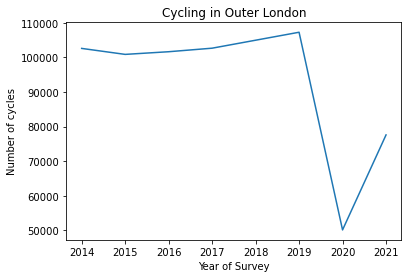

In [26]:
# Create the line chart
plt.plot(df['Survey_wave_(year)'], df['Total_cycles'])

# Adding the aesthetics
plt.title("Cycling in Outer London")
plt.xlabel('Year of Survey')
plt.ylabel('Number of cycles')

# Show the plot
plt.show()

## Does the time of the day matter?

In [27]:
# Aggregate by time of day

df= central_london.groupby(['Period'], as_index=False)['Total_cycles'].count()
df.sort_values('Total_cycles', inplace = True)

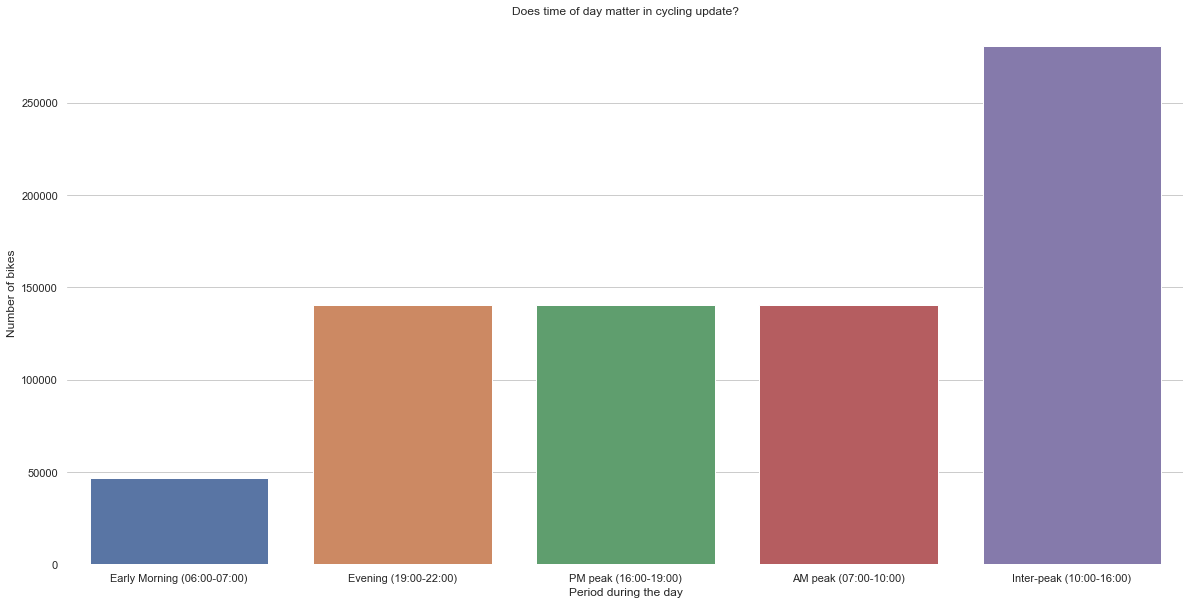

In [28]:
# Chart to view time of day with highest cycling count
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (20,10))

g=sns.barplot(x = df['Period'], y = df['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Period during the day")
g.set_title('Does time of day matter in cycling update?')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Interpeak again most popular

## Do Seasons matter?

In [29]:
# Aggregate data by Weather
df= central_london.groupby(['season'], as_index=False)['Total_cycles'].count()
df

,season,Total_cycles
0,Autumn,199516
1,Spring,183597
2,Summer,196923
3,Winter,167651


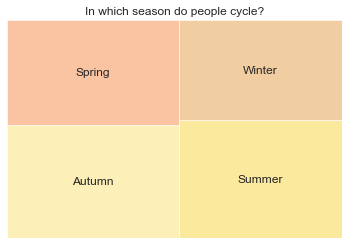

In [30]:
# Plotting a treemap
# Colour Palette
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']

# Set Plot Style
sns.set_style(style="whitegrid") 

# Setting the variable
sizes= df["Total_cycles"].values
label=df["season"]

# Setting the styles
squarify.plot(sizes=sizes, label=label, alpha=0.6,color=colors).set(title='In which season do people cycle?')
plt.axis('off')
plt.show()

# Need to ask Kevin to prettify
# Explore waffle charts
# Here seems there is much less seasonal impact!

## Does Weather Matter?

In [31]:
# Aggregate data by Weather
df= central_london.groupby(['Weather'], as_index=False)['Total_cycles'].count()
df
# Clearly a big factor. But how does this compare to other cities? 
# For within each condition what % of London is on bike versus their peers in other cities?

,Weather,Total_cycles
0,Dangerous Weather,2966
1,Good,648891
2,Light Rain,1394
3,Rain,89738
4,Unknown,4698


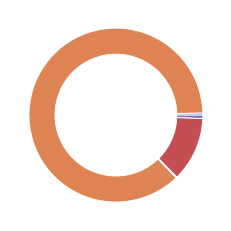

In [34]:
# Plot Pie Chart
# create data
names = ['Dangerous Weather', 'Good', 'Light Rain', 'Rain', 'Unknown']
size = [2966,648891,1394,89738,4698]


# Create a pieplot
plt.pie(size_of_groups)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

# Ask Kevin to prettify

In [ ]:
# More Variables & Merge Data Set.